In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_probe = pd.read_csv("module_level_aggregations_data.csv")

In [5]:
del data

In [209]:
#Remove all columns with None
df_probe[df_probe == 'None'] = np.nan
df_probe = df_probe.dropna(axis = 1, how ='any')


In [212]:
#Load Dell Data
df_dell = pd.read_csv("dell.csv")


#df_dell.to_csv("dell.csv", index=False)

# Keep only PASS or VID
print(df_dell.shape)
df_dell = df_dell[(df_dell.response == 'PASS') | (df_dell.response == 'VID') ]
df_dell.head(3)
print(df_dell.shape)

# Drop FA Dispo and FAE Verification columns

df_dell = df_dell.drop(columns = [ 'FA.Disposition', 'FAE.Verification'] )


(979957, 6)
(979688, 6)


In [16]:
# Join both pandas on key=MSN .
df_join_prb_dell = pd.merge(df_probe, df_dell, how='inner', on=['MSN'])
print(df_join_prb_dell.shape)
df_join_prb_dell.head(2)

#Rename Column names in dell df.
df_join_prb_dell.rename(columns={'Fiscal.Month..MM.': 'MM', 'Fiscal.Year..YYYY.': 'YYYY'}, inplace=True)
df_join_prb_dell.columns

# Grab data only for Months 4,5,6
df_month456 = df_join_prb_dell.query('MM ==4 | MM ==5 | MM ==6')

#Change response to numerical
df_month456.response.replace(to_replace=dict(PASS=1, VID=0), inplace=True)

# drop Nan columns
df_month456 = df_month456.dropna(axis=0, how='all')



(1069872, 44)


C:\Users\sayyapureddi\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [122]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
df_month456 = df_month456.drop(columns=['MM','YYYY'])
df_train, df_test = train_test_split(df_month456, test_size=0.2, stratify=df_month456['response'])

## Data description:  This data set has 40 features and has a binary classification. This data is highly imbalanced. The majority class is 98%.

The data was scaled initially. Dimentionality reduction included looking at PCA. 95% of the variance was captured by 19 features. The data was scaled accordingly.

Given the imbalanced nature of the data, the first attempt at classification fared poorly. I then decided to balance out the data using the GMM algorithm. I filled in additional data using the GMM algorithm. The algorithm identified 4 distributions. 

The data almost double on account of the balancing of the class. At ths point the data shot up to 240K rows of data. 

Based on the large data set and also the large amount of features, I decided that some of the algorithms had to be ruled out. SVM with kernels as predicted would not finsih even after 15 mins, at which time I retarted the Jupyter kernel.

I also ran feature importance algo`s in the hope of finding something useful. All the features more or less had the same features. I also tried using DBSCAN to see if it would result in some sort of insight. DBSCAN had difficulty carrying out clustering. 

As a last resort , I tried using Adaboost with decision trees to see if it would be successful. This gave a 50% mean accuracy. The results are tabulated in the rest of the notebook.

In [123]:
X_train = df_train.iloc[:,1:41]
y_train = df_train.iloc[:,41]

X_test = df_test.iloc[:,1:41]
y_test = df_test.iloc[:,41]

scaler = StandardScaler()
XS_train=scaler.fit_transform(X_train) 
XS_test=scaler.transform(X_test)

### Dimensionality Reduction using PCA

In [92]:
from sklearn.decomposition import PCA 


pca_sub = PCA(n_components=XS_train.shape[1]) #2-dimensional PCA
pca_sub.fit_transform(XS_train)
cum_array = pca_sub.explained_variance_ratio_.cumsum()
print(cum_array)

[ 0.21931869  0.38952332  0.47826782  0.55081303  0.60524108  0.65612963
  0.70437282  0.74240625  0.7775609   0.80784088  0.83690682  0.86491177
  0.8874353   0.90314211  0.91669936  0.92929292  0.94145628  0.94928191
  0.95643024  0.9626873   0.96831925  0.97263399  0.97649719  0.9793418
  0.98203934  0.98460186  0.98695689  0.98908492  0.99104673  0.99280784
  0.99414857  0.9954071   0.99662193  0.99763109  0.99844157  0.99913165
  0.99970347  1.          1.          1.        ]


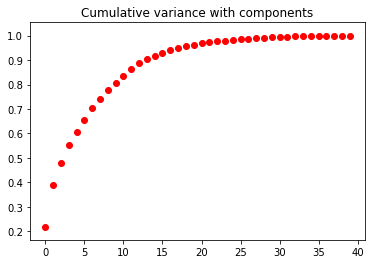

In [93]:
plt.scatter(range(XS_train.shape[1]), cum_array, color='red')
plt.title("Cumulative variance with components")

### 18 components capture 95% of the variance.

In [94]:
pca_sub = PCA(n_components=18) # 15-dimensional PCA
XPCA_train = pd.DataFrame(pca_sub.fit_transform(XS_train))
XPCA_test = pd.DataFrame(pca_sub.fit_transform(XS_test))

In [120]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=20)
clf.fit(XPCA_train, y_train)

y_pred = clf.predict(XPCA_test)
ytr_pred = clf.predict(XPCA_train)

In [121]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score
from sklearn.metrics import f1_score

print('Accuracy train', accuracy_score(y_train, ytr_pred))
print('confusion matrix train',confusion_matrix(y_train, ytr_pred))
print('fscore ',f1_score(y_train, ytr_pred))
print('Accuracy', accuracy_score(y_test, y_pred))
print('confusion matrix',confusion_matrix(y_test, y_pred))
print('fscore ',f1_score(y_test, y_pred))

Accuracy train 1.0
confusion matrix train [[    54      0]
 [     0 124506]]
fscore  1.0
Accuracy 0.999068721901
confusion matrix [[    0    13]
 [   16 31111]]
fscore  0.99953414403


### As this is a very imbalanced data set, I will attempt to balance it by using GMM.

One question which comes to my mind is wether it makes a difference to balance out the test set too. My understanding si that the test step only involves inference and hence it does not make a diference to balance out the test data.

In [128]:
df_fails = df_train[df_train['response'] == 0]
X_set =df_fails.iloc[:,1:41].values

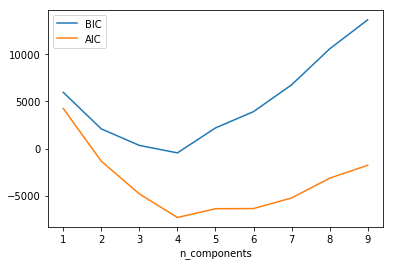

In [131]:
from sklearn.mixture import GaussianMixture

n_components =range(1,10)
clfs = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_set)
          for n in range(1,10)]

plt.plot(n_components, [m.bic(X_set) for m in clfs], label='BIC')
plt.plot(n_components, [m.aic(X_set) for m in clfs], label='AIC')

plt.legend(loc='best')
plt.xlabel('n_components');

### The above plot indicates that there are 4 distributions in the data space.

In [132]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=0)
gmm.fit(X_set)
#Check for gmm convergence
print(gmm.converged_) 

True


In [133]:
# Generate samples
new_set = gmm.sample(124452)

In [134]:
new_set.count

<function tuple.count>

In [140]:
df_gen_minority =pd.DataFrame(new_set[0])

In [161]:
X_train_new = np.vstack((X_train,new_set[0]))
y_gen_min = np.zeros(new_set[0].shape[0]).reshape(124452,1)
y_train_new = np.append(y_train,y_gen_min)

In [163]:
scaler = StandardScaler()
XS_train=scaler.fit_transform(X_train_new) 
XS_test=scaler.transform(X_test)

In [164]:
from sklearn.decomposition import PCA 


pca_sub = PCA(n_components=XS_train.shape[1]) #2-dimensional PCA
pca_sub.fit_transform(XS_train)
cum_array = pca_sub.explained_variance_ratio_.cumsum()
print(cum_array)

[ 0.22726557  0.37297123  0.46454959  0.53131506  0.58823788  0.63459986
  0.67974828  0.71413653  0.74661955  0.776475    0.80332617  0.82840721
  0.85337963  0.87833388  0.90029795  0.91615113  0.92834087  0.93899725
  0.94742045  0.95526121  0.960733    0.96570568  0.97033002  0.97446078
  0.97798671  0.9808698   0.98332674  0.9856526   0.98767183  0.98964054
  0.99155243  0.99309494  0.99443083  0.9957333   0.99688945  0.99789984
  0.99864884  0.99930141  0.99975637  1.        ]


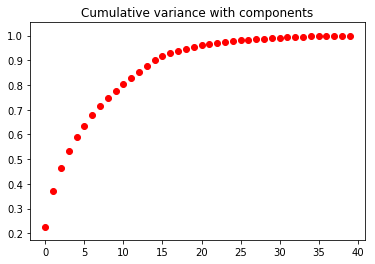

In [165]:
plt.scatter(range(XS_train.shape[1]), cum_array, color='red')
plt.title("Cumulative variance with components")

### 19 components capture 95% of the variance.

In [173]:
pca_sub = PCA(n_components=19) # 19-dimensional PCA
XPCA_train = pd.DataFrame(pca_sub.fit_transform(XS_train))
XPCA_test = pd.DataFrame(pca_sub.fit_transform(XS_test))

In [176]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth=15)
clf.fit(XPCA_train, y_train_new)

y_pred = clf.predict(XPCA_test)
ytr_pred = clf.predict(XPCA_train)

In [177]:
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support,accuracy_score
from sklearn.metrics import f1_score

print('Accuracy train', accuracy_score(y_train_new, ytr_pred))
print('confusion matrix train',confusion_matrix(y_train_new, ytr_pred))
print('fscore ',f1_score(y_train_new, ytr_pred))
print('Accuracy', accuracy_score(y_test, y_pred))
print('confusion matrix',confusion_matrix(y_test, y_pred))
print('fscore ',f1_score(y_test, y_pred))

Accuracy train 0.95349621705
confusion matrix train [[113348  11158]
 [   422 124084]]
fscore  0.955418328534
Accuracy 0.340687219011
confusion matrix [[    7     6]
 [20525 10602]]
fscore  0.508062777046


Feature ranking:
1. feature 12 (0.173780)
2. feature 13 (0.155264)
3. feature 11 (0.148119)
4. feature 1 (0.057121)
5. feature 0 (0.056038)
6. feature 18 (0.041434)
7. feature 2 (0.040694)
8. feature 16 (0.036406)
9. feature 3 (0.030719)
10. feature 10 (0.030471)
11. feature 14 (0.029930)
12. feature 17 (0.029819)
13. feature 5 (0.029549)
14. feature 4 (0.027409)
15. feature 9 (0.026790)
16. feature 15 (0.024020)
17. feature 6 (0.023171)
18. feature 8 (0.020528)
19. feature 7 (0.018736)


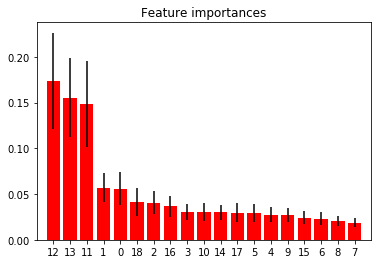

In [183]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier




# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(XPCA_train, y_train_new)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(XPCA_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(XPCA_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(XPCA_train.shape[1]), indices)
plt.xlim([-1, XPCA_train.shape[1]])
plt.show()

### Using DBSCAN

In [196]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=10).fit(XPCA_train)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
#dict_eps[ep] = n_clusters

In [197]:
n_clusters

769

In [201]:
from sklearn.svm import SVC

gamma_rbf = [0.1]
SVMtrainAcc = []
SVMtestAcc = []

for param in gamma_rbf:
    clf = SVC(C=param,kernel='rbf',gamma='auto')
    clf.fit(XPCA_train, y_train_new)
    Y_predTrain = clf.predict(XPCA_train)
    Y_predTest = clf.predict(XPCA_test)
    SVMtrainAcc.append(accuracy_score(y_train_new, Y_predTrain))
    SVMtestAcc.append(accuracy_score(y_test, Y_predTest))

plt.plot(gamma_rbf, SVMtrainAcc, 'ro-', gamma_rbf, SVMtestAcc,'bv--')
plt.legend(['Training Accuracy','Test Accuracy'])
plt.xlabel('C')
plt.xscale('log')
plt.ylabel('Accuracy')

KeyboardInterrupt: 

In [202]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(XPCA_train, y_train_new) 

y_pred = clf.predict(XPCA_test)



clf.feature_importances_ 


clf.score(XPCA_test, y_test)

0.52228644829800897

In [200]:
clf.feature_importances_ 

array([ 0.07,  0.1 ,  0.05,  0.02,  0.05,  0.08,  0.02,  0.02,  0.02,
        0.04,  0.05,  0.07,  0.1 ,  0.08,  0.04,  0.04,  0.08,  0.03,  0.04])

array([ 1.,  0.,  0., ...,  0.,  1.,  0.])